In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
import torchvision
from torch.utils import data
from torchvision import transforms
from time import time
import multiprocessing as mp

#from torchtoolbox.tools import mixup_data, mixup_criterion

In [2]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 48

        self.conv1 = nn.Conv2d(3, 48, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(48)
        self.layer1 = self._make_layer(block, 48, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 96, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 192, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 384, num_blocks[3], stride=2)
        self.linear = nn.Linear(384, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def project1_model():
    return ResNet(BasicBlock, [1, 2, 4, 1])

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [3]:
def mixup_data(x, y, alpha=1.0, use_cuda=True):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [4]:
transform_train = torchvision.transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    #Cutout(n_holes=1, length=16),  
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=256, shuffle=True, num_workers=1)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=1000, shuffle=False, num_workers=1)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


In [5]:
net = project1_model()

num = count_parameters(net)
print(num)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50) 
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

train_loss_list = []
train_acc_list = []
#train_dur_list = []
test_loss_list = []
test_acc_list = []
#test_dur_list = []



4919674


In [6]:
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    batch_index = 0
    t0 = time()
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        inputs, targets_a, targets_b, lam = mixup_data(inputs, targets,1.)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        # loss = nll(outputs, targets)
        
        #loss = criterion(outputs, targets)
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        loss.backward()
        optimizer.step()

        batch_index = batch_idx
        # train_loss += loss.item()
        train_loss = loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += (lam * predicted.eq(targets_a.data).sum().float()
                    + (1 - lam) * predicted.eq(targets_b.data).sum().float()).item()

        #print(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                     #% (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
        #print("\n")
    train_loss_list.append(train_loss/(batch_index+1))
    train_acc_list.append(100.*correct/total)
    print(' Train: Loss: %.6f | Acc: %.3f%% | Dur: %.2fS' 
          % (train_loss/(batch_index+1), 100.*correct/total, time() - t0))

def test(epoch):
#     global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    batch_index = 0
    t0 = time()
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            # loss = nll(outputs, targets)
            batch_index = batch_idx
            # test_loss += loss.item()
            test_loss = loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            #print(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         #% (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
            #print("\n")
    test_loss_list.append(test_loss/(batch_index+1))
    test_acc_list.append(100.*correct/total)
    print(' Test:  Loss: %.6f | Acc: %.3f%% | Dur: %.2fS' 
          % (test_loss/(batch_index+1), 100.*correct/total, time() - t0))

    # Save checkpoint.
#     acc = 100.*correct/total
#     if acc > best_acc:
#         print('Saving..')
#         state = {
#             'net': net.state_dict(),
#             'acc': acc,
#             'epoch': epoch,
#             'train_history': (train_loss_list, train_acc_list, test_loss_list, test_acc_list)
#         }
#         if not os.path.isdir('checkpoint'):
#             os.mkdir('checkpoint')
#         torch.save(state, './checkpoint/ckpt_rmsprop.pth')
#         best_acc = acc


def plot_model(train_loss, train_acc, test_loss, test_acc):
    length = len(train_acc)
    plt.subplot(2, 2, 1)
    plt.plot(range(length), train_acc)
    plt.title('Train accuracy vs. epoches')
    plt.ylabel('Train accuracy')
    plt.xlabel('epoch')
    plt.subplot(2, 2, 2)
    plt.plot(range(length), train_loss)
    plt.title('Train loss vs. epoches')
    plt.ylabel('Train loss')
    plt.xlabel('epoch')
    plt.subplot(2, 2, 3)
    plt.plot(range(length), test_acc)
    plt.title('Test accuracy vs. epoches')
    plt.ylabel('Test accuracy')
    plt.xlabel('epoch')
    plt.subplot(2, 2, 4)
    plt.plot(range(length), test_loss)
    plt.title('Test loss vs. epoches')
    plt.ylabel('Test loss')
    plt.xlabel('epoch')
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.6, 
                    hspace=0.8)

In [7]:
for epoch in range(350):
    train(epoch)
    test(epoch)
    scheduler.step()


Epoch: 0
 Train: Loss: 0.009293 | Acc: 31.759% | Dur: 22.19S
 Test:  Loss: 0.132873 | Acc: 50.730% | Dur: 3.23S

Epoch: 1
 Train: Loss: 0.008121 | Acc: 44.282% | Dur: 15.59S
 Test:  Loss: 0.130401 | Acc: 55.030% | Dur: 3.32S

Epoch: 2
 Train: Loss: 0.007897 | Acc: 50.066% | Dur: 15.83S
 Test:  Loss: 0.113369 | Acc: 61.390% | Dur: 3.42S

Epoch: 3
 Train: Loss: 0.008758 | Acc: 54.132% | Dur: 15.55S
 Test:  Loss: 0.090684 | Acc: 70.760% | Dur: 3.19S

Epoch: 4
 Train: Loss: 0.004556 | Acc: 55.683% | Dur: 15.54S
 Test:  Loss: 0.083128 | Acc: 71.020% | Dur: 3.34S

Epoch: 5
 Train: Loss: 0.005762 | Acc: 57.883% | Dur: 15.97S
 Test:  Loss: 0.087087 | Acc: 72.120% | Dur: 3.41S

Epoch: 6
 Train: Loss: 0.008645 | Acc: 59.248% | Dur: 16.15S
 Test:  Loss: 0.075798 | Acc: 75.960% | Dur: 3.42S

Epoch: 7
 Train: Loss: 0.005212 | Acc: 61.216% | Dur: 21.15S
 Test:  Loss: 0.072581 | Acc: 76.230% | Dur: 3.49S

Epoch: 8
 Train: Loss: 0.008462 | Acc: 61.608% | Dur: 20.54S
 Test:  Loss: 0.070692 | Acc: 78.9

 Train: Loss: 0.007289 | Acc: 68.315% | Dur: 13.77S
 Test:  Loss: 0.047882 | Acc: 88.510% | Dur: 2.97S

Epoch: 73
 Train: Loss: 0.002384 | Acc: 70.999% | Dur: 13.95S
 Test:  Loss: 0.038816 | Acc: 89.710% | Dur: 3.04S

Epoch: 74
 Train: Loss: 0.005524 | Acc: 70.748% | Dur: 13.88S
 Test:  Loss: 0.040355 | Acc: 90.170% | Dur: 2.97S

Epoch: 75
 Train: Loss: 0.005147 | Acc: 70.681% | Dur: 14.15S
 Test:  Loss: 0.045923 | Acc: 89.950% | Dur: 3.02S

Epoch: 76
 Train: Loss: 0.006888 | Acc: 69.126% | Dur: 14.40S
 Test:  Loss: 0.055088 | Acc: 85.810% | Dur: 3.06S

Epoch: 77
 Train: Loss: 0.006577 | Acc: 69.184% | Dur: 14.06S
 Test:  Loss: 0.046314 | Acc: 90.050% | Dur: 3.05S

Epoch: 78
 Train: Loss: 0.007257 | Acc: 68.744% | Dur: 14.33S
 Test:  Loss: 0.041282 | Acc: 90.120% | Dur: 3.00S

Epoch: 79
 Train: Loss: 0.006659 | Acc: 71.216% | Dur: 14.16S
 Test:  Loss: 0.048538 | Acc: 88.500% | Dur: 3.04S

Epoch: 80
 Train: Loss: 0.007231 | Acc: 70.927% | Dur: 13.94S
 Test:  Loss: 0.045739 | Acc: 87.410

 Train: Loss: 0.005142 | Acc: 72.691% | Dur: 14.04S
 Test:  Loss: 0.037732 | Acc: 93.690% | Dur: 2.97S

Epoch: 145
 Train: Loss: 0.002004 | Acc: 75.518% | Dur: 13.67S
 Test:  Loss: 0.030579 | Acc: 94.110% | Dur: 3.02S

Epoch: 146
 Train: Loss: 0.004062 | Acc: 74.316% | Dur: 13.89S
 Test:  Loss: 0.035136 | Acc: 93.920% | Dur: 3.02S

Epoch: 147
 Train: Loss: 0.002066 | Acc: 74.967% | Dur: 13.70S
 Test:  Loss: 0.031135 | Acc: 93.970% | Dur: 2.97S

Epoch: 148
 Train: Loss: 0.001460 | Acc: 73.003% | Dur: 13.63S
 Test:  Loss: 0.035135 | Acc: 94.060% | Dur: 2.96S

Epoch: 149
 Train: Loss: 0.003446 | Acc: 75.957% | Dur: 14.15S
 Test:  Loss: 0.032720 | Acc: 93.980% | Dur: 3.01S

Epoch: 150
 Train: Loss: 0.004054 | Acc: 73.597% | Dur: 13.99S
 Test:  Loss: 0.033232 | Acc: 93.930% | Dur: 3.01S

Epoch: 151
 Train: Loss: 0.006132 | Acc: 74.549% | Dur: 13.76S
 Test:  Loss: 0.037159 | Acc: 93.920% | Dur: 2.98S

Epoch: 152
 Train: Loss: 0.001555 | Acc: 73.495% | Dur: 13.81S
 Test:  Loss: 0.032695 | Acc

 Test:  Loss: 0.033769 | Acc: 92.410% | Dur: 2.75S

Epoch: 216
 Train: Loss: 0.006039 | Acc: 73.278% | Dur: 12.80S
 Test:  Loss: 0.043943 | Acc: 92.490% | Dur: 2.76S

Epoch: 217
 Train: Loss: 0.004079 | Acc: 74.387% | Dur: 13.23S
 Test:  Loss: 0.037846 | Acc: 92.930% | Dur: 2.79S

Epoch: 218
 Train: Loss: 0.001576 | Acc: 74.027% | Dur: 13.28S
 Test:  Loss: 0.037731 | Acc: 92.450% | Dur: 2.74S

Epoch: 219
 Train: Loss: 0.005720 | Acc: 74.528% | Dur: 13.03S
 Test:  Loss: 0.039850 | Acc: 92.830% | Dur: 2.83S

Epoch: 220
 Train: Loss: 0.006564 | Acc: 72.662% | Dur: 13.06S
 Test:  Loss: 0.040091 | Acc: 92.410% | Dur: 2.74S

Epoch: 221
 Train: Loss: 0.005028 | Acc: 73.240% | Dur: 13.14S
 Test:  Loss: 0.032790 | Acc: 93.610% | Dur: 2.80S

Epoch: 222
 Train: Loss: 0.005831 | Acc: 72.016% | Dur: 12.92S
 Test:  Loss: 0.037082 | Acc: 92.690% | Dur: 2.74S

Epoch: 223
 Train: Loss: 0.004482 | Acc: 72.864% | Dur: 12.98S
 Test:  Loss: 0.042090 | Acc: 92.680% | Dur: 2.75S

Epoch: 224
 Train: Loss: 0.0

 Train: Loss: 0.005995 | Acc: 72.925% | Dur: 13.20S
 Test:  Loss: 0.039111 | Acc: 92.850% | Dur: 2.76S

Epoch: 288
 Train: Loss: 0.005435 | Acc: 73.609% | Dur: 13.02S
 Test:  Loss: 0.037621 | Acc: 92.920% | Dur: 2.79S

Epoch: 289
 Train: Loss: 0.001619 | Acc: 72.012% | Dur: 13.20S
 Test:  Loss: 0.043174 | Acc: 92.010% | Dur: 2.79S

Epoch: 290
 Train: Loss: 0.005578 | Acc: 75.890% | Dur: 13.04S
 Test:  Loss: 0.039668 | Acc: 91.640% | Dur: 2.80S

Epoch: 291
 Train: Loss: 0.001348 | Acc: 73.890% | Dur: 12.97S
 Test:  Loss: 0.042233 | Acc: 92.540% | Dur: 2.74S

Epoch: 292
 Train: Loss: 0.001897 | Acc: 72.624% | Dur: 13.10S
 Test:  Loss: 0.038836 | Acc: 92.270% | Dur: 2.79S

Epoch: 293
 Train: Loss: 0.006316 | Acc: 73.059% | Dur: 13.08S
 Test:  Loss: 0.042070 | Acc: 91.540% | Dur: 2.77S

Epoch: 294
 Train: Loss: 0.004214 | Acc: 72.070% | Dur: 13.00S
 Test:  Loss: 0.043386 | Acc: 91.460% | Dur: 2.73S

Epoch: 295
 Train: Loss: 0.001261 | Acc: 71.973% | Dur: 13.02S
 Test:  Loss: 0.037596 | Acc

In [8]:
print(train_acc_list)
print(train_loss_list)

[31.759209213256835, 44.28160115051269, 50.065521484375, 54.132131088256834, 55.68267283630371, 57.88259049987793, 59.24815960693359, 61.21552741241455, 61.60835682678223, 59.85467024993896, 62.10626628112793, 61.1074493637085, 64.27416383361816, 65.85942449951172, 63.43105924224854, 65.84024417114257, 67.34741439819337, 66.43781379699708, 68.37329998779298, 66.642528175354, 66.77693518066407, 65.43033251953125, 67.77642176055909, 68.50190144348144, 67.92922073364258, 70.0279907913208, 65.82971710205078, 71.84295616149902, 66.97820288848877, 70.67465957641602, 68.83794281768799, 68.56817457580567, 70.72574715423583, 70.36296324920654, 70.61705590820313, 68.9280705871582, 70.59980050659179, 71.49171892547608, 70.4856842803955, 71.16313313293458, 70.18368190002441, 71.7357285079956, 69.45175349426269, 69.57228665161132, 70.30346116638184, 70.75873105621338, 70.54133492279053, 70.3129175567627, 72.58843574523925, 72.38545442199707, 71.02622521972657, 72.28420262145995, 68.93374617004395, 

In [9]:
print(test_acc_list)
print(test_loss_list)

[50.73, 55.03, 61.39, 70.76, 71.02, 72.12, 75.96, 76.23, 78.98, 79.8, 82.22, 82.39, 79.52, 82.98, 84.54, 82.91, 82.99, 84.24, 85.62, 85.6, 85.44, 86.44, 87.11, 87.81, 87.92, 87.07, 88.74, 87.62, 87.72, 88.83, 88.37, 89.21, 90.02, 89.47, 90.05, 90.3, 90.62, 90.49, 91.12, 90.9, 90.96, 90.94, 91.56, 91.57, 90.94, 91.28, 91.53, 91.3, 91.17, 91.31, 91.37, 91.37, 91.11, 91.54, 91.63, 91.49, 91.11, 91.43, 91.15, 91.4, 90.76, 91.1, 91.09, 90.81, 90.52, 89.89, 90.03, 90.15, 89.12, 90.14, 88.62, 89.03, 88.51, 89.71, 90.17, 89.95, 85.81, 90.05, 90.12, 88.5, 87.41, 88.77, 89.07, 87.51, 87.72, 83.98, 88.9, 89.52, 87.99, 89.39, 89.38, 87.86, 86.04, 89.18, 89.41, 86.93, 90.28, 88.88, 88.86, 88.1, 87.87, 88.54, 90.39, 89.78, 89.19, 89.94, 90.82, 88.88, 91.18, 88.52, 91.62, 91.35, 89.86, 91.37, 90.21, 91.79, 90.13, 90.99, 92.07, 91.96, 92.05, 92.17, 92.54, 92.6, 92.66, 92.75, 92.77, 92.66, 92.46, 93.2, 93.24, 93.26, 93.23, 93.03, 93.38, 93.48, 93.37, 93.98, 93.84, 93.58, 93.82, 94.01, 93.97, 93.92, 93.

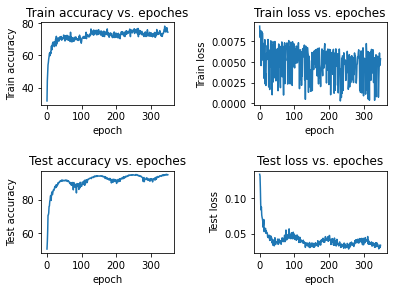

In [10]:
plot_model(train_loss_list,train_acc_list,test_loss_list,test_acc_list)

In [12]:
model_path = './project1_model.pt'
torch.save(net.state_dict(), model_path)

In [ ]:
from project1_model import project1_model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = project1_model().to(device)
model_path = './project1_model.pt'
model.load_state_dict(torch.load(model_path, map_location=device), strict=False)